In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
df_chunk = pd.read_csv('train.csv',chunksize=1000000)

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    chunk_list.append(chunk)
    
# concat the list into dataframe 
dataset = pd.concat(chunk_list)

In [269]:
# Lookback time feature
def add_time_diff(df, ori_col, shift_count):
    shift = df[ori_col].shift(shift_count)
    new_col = ori_col + str(shift_count)
    df[new_col] = shift
    return df

def preprocess_data(train_dataset):
    print('Loading dataset')
    # remove nrows count when saving data
    #train_dataset = pd.read_csv('data/train.csv', nrows=10000)
    holidays_dataset = pd.read_csv('data/holidays_events.csv')
    item_dataset = pd.read_csv('data/items.csv')
    store_dataset = pd.read_csv('data/stores.csv')
    oil_dataset = pd.read_csv('data/oil.csv')

    min_date = min(train_dataset['date'])
    max_date = max(train_dataset['date'])
    # Create new DataFrame to take into account missing data
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    date_range[:10]

    train_df = pd.DataFrame(date_range, columns=['date'])
    train_df['unit_sales'] = 0

    train_dataset['date'] = pd.to_datetime(train_dataset['date'])
    train_df = train_df.merge(train_dataset, how='left', on='date').drop(['unit_sales_x'], axis=1).fillna(0)
    train_df.rename(columns={'unit_sales_y': 'unit_sales'}, inplace=True)

    for day in range(1,8):
        train_df = add_time_diff(train_df, 'unit_sales', day)
        
    train_df['onpromotion_cat'] = train_df['onpromotion'].apply(lambda x: 0 if x==False else 1)
    train_df = train_df.drop(['onpromotion'],axis =1)
    
    # Get date features
    train_df['year'] = train_df['date'].dt.year
    train_df['day_of_year'] = train_df['date'].dt.dayofyear
    train_df['day_of_week'] = train_df['date'].dt.weekday
    train_df['week_of_year'] = train_df['date'].dt.week
    train_df['month'] = train_df['date'].dt.month
    train_df['quarter'] = train_df['date'].dt.quarter
    train_df["weekday"] = (train_df["day_of_week"] < 5).astype(int)
    '''
    # Get holiday features
    holidays_dataset['date'] = pd.to_datetime(holidays_dataset['date'])
    holidays_dataset = pd.get_dummies(holidays_dataset, columns=['locale','locale_name', 'type'], prefix=['locale','locale_name', 'holiday_type'])
    holidays_dataset = holidays_dataset.drop(columns=['description','transferred'])
    train_df = train_df.merge(holidays_dataset, how='left', on='date')
    train_df.rename(columns={'type': 'holiday_type'}, inplace=True)

    # Get item features
    item_dataset = pd.get_dummies(item_dataset, columns=['family'], prefix=['family'])
    item_dataset = item_dataset.drop(columns=['class'])
    train_df = train_df.merge(item_dataset, how='left', on='item_nbr')

    # Get store features
    store_dataset['city_state'] = store_dataset[['city', 'state']].apply(lambda x: '_'.join(x), axis=1)
    store_dataset = pd.get_dummies(store_dataset, columns=['city_state', 'type'], prefix=['city_state', 'store_type'])
    store_dataset = store_dataset.drop(columns=['city', 'state'])
    train_df = train_df.merge(store_dataset, how='left', on='store_nbr')
    train_df.rename(columns={'type': 'location_type'}, inplace=True)
    '''
    # Get oil features
    oil_dataset['date'] = pd.to_datetime(oil_dataset['date'])
    oil_dataset = oil_dataset.sort_values(by=['date'], ascending=[True])
    oil_dataset.set_index('date', inplace=True)
    oil_dataset = oil_dataset.resample('D').ffill().reset_index()
    train_df = train_df.merge(oil_dataset, how='left', on='date')
    
    train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='ffill')
    train_df = train_df.fillna(0)
    # Encoding for tree-based methods
    # DONE
    
    print('@create_dataset - done with preprocess')
    return train_df

#dataset = preprocess_data()
#print(dataset.head())
#print(dataset.columns)

In [270]:
print(dataset['store_nbr'].unique())

[25  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 24 26 27
 28 30 31 32 33 34 35 37 38 39 40 41 43 44 45 46 47 48 49 50 51 54 36 53
 20 29 21 42 22 52]


In [271]:
#taking only store 44 and item number 1503844
trimmed_df = dataset[(dataset['store_nbr'] == 44) & (dataset['item_nbr'] == 1503844)].reset_index()
#trimmed_df = trimmed_df.drop(['index'],axis=1)
trimmed_df.to_excel('trimmed_df.xlsx',index = False)

In [272]:
df = preprocess_data(trimmed_df)
df.to_excel('df.xlsx')
df.columns.values
df = df.drop(['index','id','store_nbr','item_nbr'],axis = 1)
df.to_excel('df_for_time_seris.xlsx',index = False)
y = df['unit_sales']
df = df.drop(['unit_sales'],axis = 1)
df['y'] = y

Loading dataset
@create_dataset - done with preprocess


In [273]:
df

,date,unit_sales1,unit_sales2,unit_sales3,unit_sales4,unit_sales5,unit_sales6,unit_sales7,onpromotion_cat,year,day_of_year,day_of_week,week_of_year,month,quarter,weekday,dcoilwtico,y
0,2014-01-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,2014,2,3,1,1,1,1,95.1400,966.1490
1,2014-01-03,966.1490,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,2014,3,4,1,1,1,1,93.6600,663.4050
2,2014-01-04,663.4050,966.1490,0.0000,0.0000,0.0000,0.0000,0.0000,0,2014,4,5,1,1,1,0,93.6600,1075.0000
3,2014-01-05,1075.0000,663.4050,966.1490,0.0000,0.0000,0.0000,0.0000,0,2014,5,6,1,1,1,0,93.6600,892.6080
4,2014-01-06,892.6080,1075.0000,663.4050,966.1490,0.0000,0.0000,0.0000,0,2014,6,0,2,1,1,1,93.1200,261.5540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2017-08-11,408.0320,917.4570,396.7070,668.7610,1229.7400,865.0110,720.2070,0,2017,223,4,32,8,3,1,48.8100,682.4450
1318,2017-08-12,682.4450,408.0320,917.4570,396.7070,668.7610,1229.7400,865.0110,0,2017,224,5,32,8,3,0,48.8100,720.9130
1319,2017-08-13,720.9130,682.4450,408.0320,917.4570,396.7070,668.7610,1229.7400,0,2017,225,6,32,8,3,0,48.8100,960.0430
1320,2017-08-14,960.0430,720.9130,682.4450,408.0320,917.4570,396.7070,668.7610,0,2017,226,0,33,8,3,1,47.5900,696.3690


### There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K² Test.

In [274]:
stat, p = stats.normaltest(df.y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=155.551, p=0.000
Data does not look Gaussian (reject H0)


### determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: -0.8678272109701539
Skewness of normal distribution: -0.1671493296159159


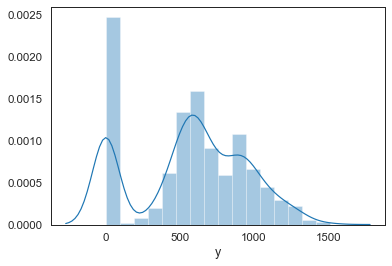

In [275]:
sns.distplot(df.y);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.y)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.y)))

#### Kurtosis: describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

#### Skewness: measures asymmetry of the distribution
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

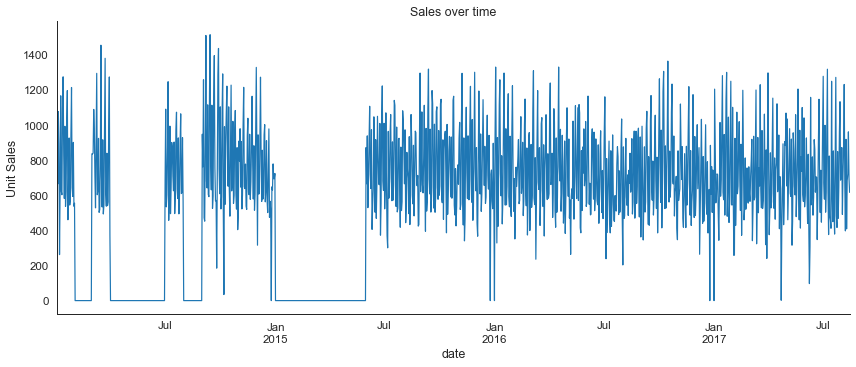

In [276]:
df1=df.loc[:,['date','y']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))

plt.ylabel('Unit Sales')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Sales over time')
sns.despine(top=True)
plt.show();

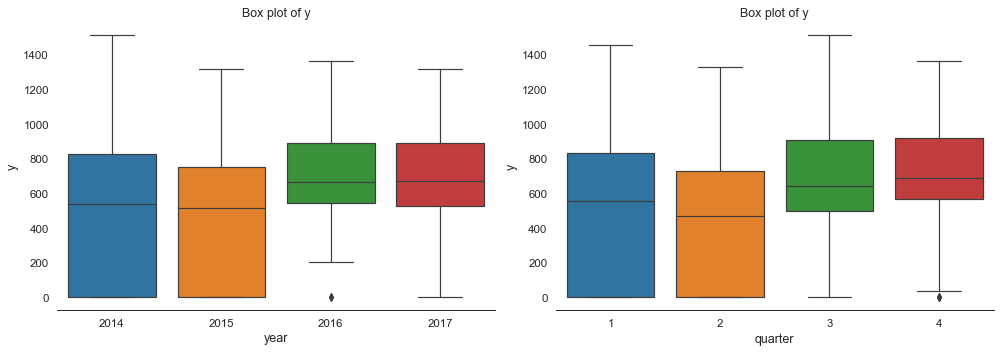

In [277]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="y", data=df)
plt.xlabel('year')
plt.title('Box plot of y')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="y", data=df)
plt.xlabel('quarter')
plt.title('Box plot of y')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
y,1322.0000,567.3405,379.5703,0.0000,346.5700,597.7350,869.3700,1512.8570


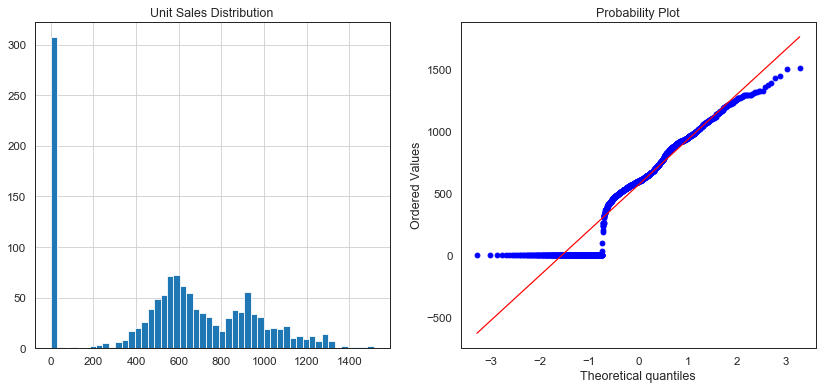

In [278]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['y'].hist(bins=50)
plt.title('Unit Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(df['y'], plot=plt);
df1.describe().T

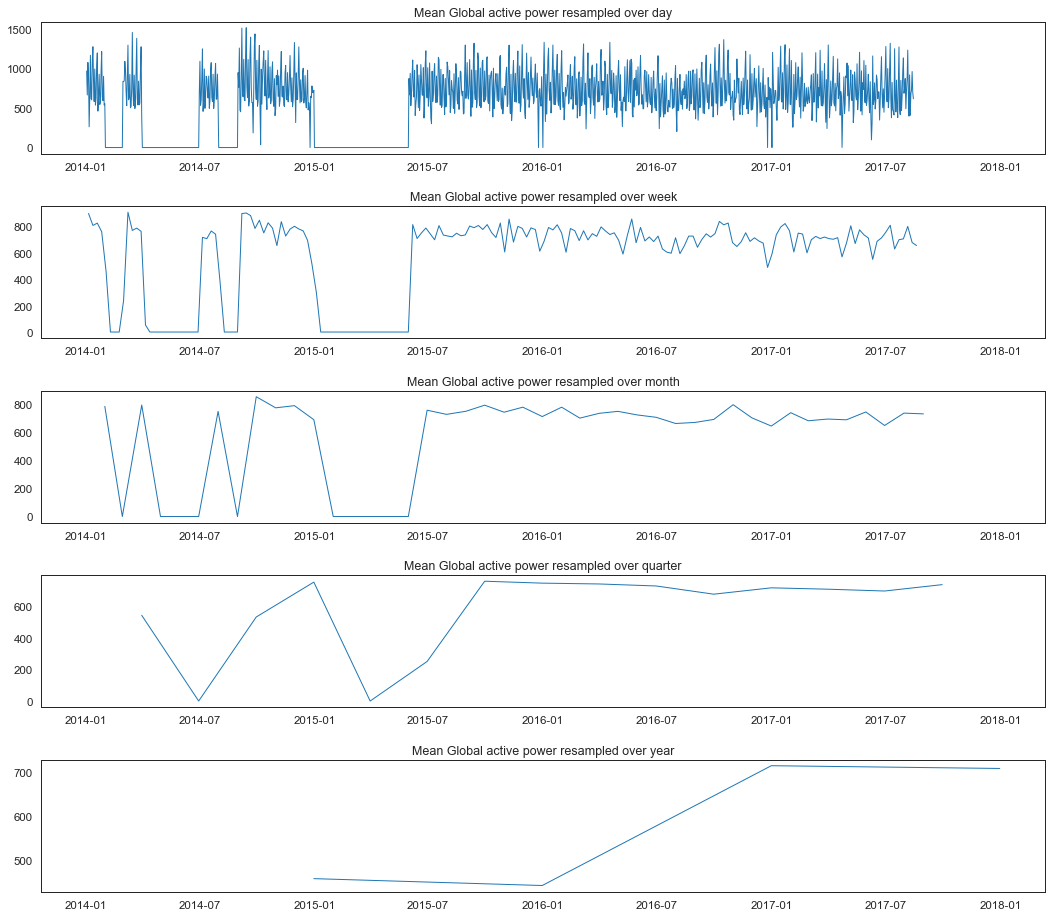

In [279]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['y'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Unit Sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['y'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Unit Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['y'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Unit Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['y'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Unit Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['y'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Unit Sales resampled over year')
ax5.tick_params(axis='both', which='major');

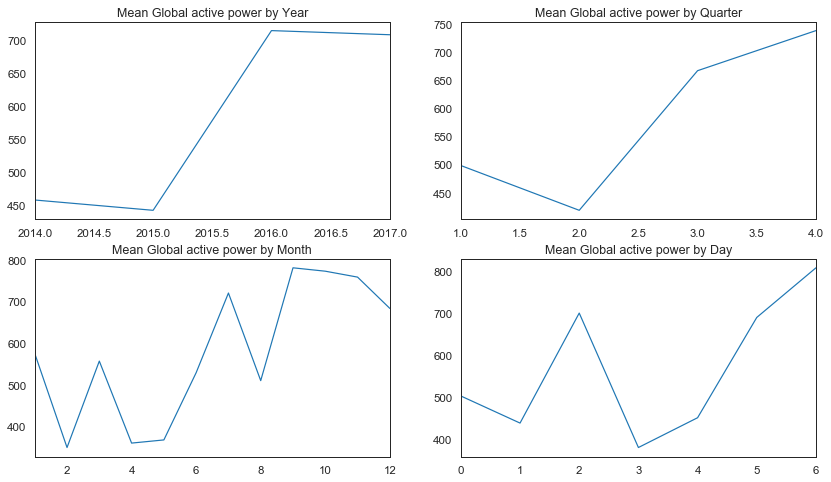

In [280]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day_of_week').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

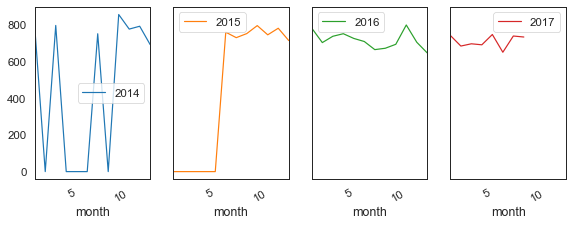

In [282]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "y", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

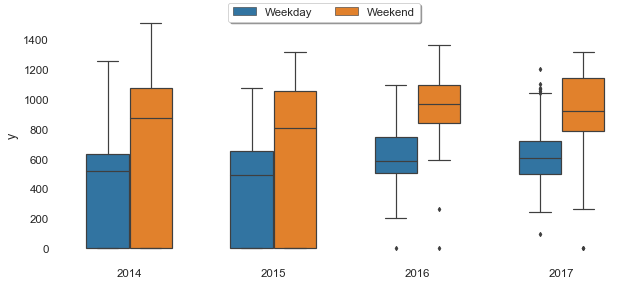

In [284]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','y',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

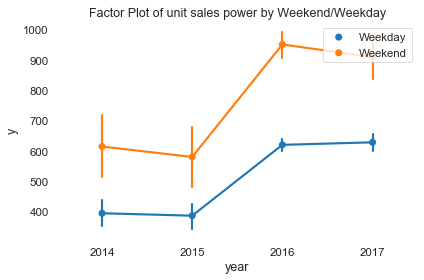

In [286]:
plt1=sns.factorplot('year','y',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of unit sales power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

### Dickey-Fuller test
#### Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
#### Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

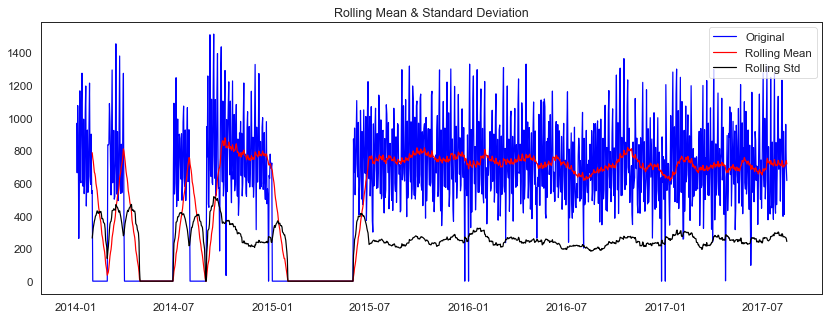

<Results of Dickey-Fuller Test>
Test Statistic                  -3.9119
p-value                          0.0019
#Lags Used                      21.0000
Number of Observations Used   1300.0000
Critical Value (1%)             -3.4354
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64


In [288]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.y.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM

In [290]:
df_temp = df.drop(['unit_sales1','unit_sales2','unit_sales3','unit_sales4','unit_sales5','unit_sales6','unit_sales6','unit_sales7'],axis = 1)
df_temp

,date,onpromotion_cat,year,day_of_year,day_of_week,week_of_year,month,quarter,weekday,dcoilwtico,y,Day
0,2014-01-02,0,2014,2,3,1,1,1,1,95.1400,966.1490,Weekday
1,2014-01-03,0,2014,3,4,1,1,1,1,93.6600,663.4050,Weekday
2,2014-01-04,0,2014,4,5,1,1,1,0,93.6600,1075.0000,Weekend
3,2014-01-05,0,2014,5,6,1,1,1,0,93.6600,892.6080,Weekend
4,2014-01-06,0,2014,6,0,2,1,1,1,93.1200,261.5540,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2017-08-11,0,2017,223,4,32,8,3,1,48.8100,682.4450,Weekday
1318,2017-08-12,0,2017,224,5,32,8,3,0,48.8100,720.9130,Weekend
1319,2017-08-13,0,2017,225,6,32,8,3,0,48.8100,960.0430,Weekend
1320,2017-08-14,0,2017,226,0,33,8,3,1,47.5900,696.3690,Weekday


### 7 Day look back unit sales only

In [374]:
dataset = df_temp.y.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

(917, 7)
(917, 1, 7) (917,)


array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.84332192],
       [0.63862546, 0.        , 0.        , ..., 0.        , 1.        ,
        0.82522016],
       [0.43851137, 0.63862546, 0.        , ..., 0.        , 0.        ,
        0.82522016],
       ...,
       [0.31489956, 0.5998789 , 0.498172  , ..., 0.66666667, 1.        ,
        0.25232387],
       [0.25472797, 0.31489956, 0.5998789 , ..., 0.66666667, 1.        ,
        0.22847358],
       [0.56359061, 0.25472797, 0.31489956, ..., 0.66666667, 1.        ,
        0.23789139]])

In [327]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=10, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 917 samples, validate on 389 samples
Epoch 1/200
917/917 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0251
Epoch 2/200
917/917 [==============================] - 0s 417us/step - loss: 0.0242 - val_loss: 0.0222
Epoch 3/200
917/917 [==============================] - 0s 412us/step - loss: 0.0212 - val_loss: 0.0199
Epoch 4/200
917/917 [==============================] - 0s 413us/step - loss: 0.0193 - val_loss: 0.0187
Epoch 5/200
917/917 [==============================] - 0s 414us/step - loss: 0.0185 - val_loss: 0.0184
Epoch 6/200
917/917 [==============================] - 0s 414us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 7/200
917/917 [==============================] - 0s 415us/step - loss: 0.0180 - val_loss: 0.0183
Epoch 8/200
917/917 [==============================] - 0s 414us/step - loss: 0.0180 - val_loss: 0.0183
Epoch 9/200
917/917 [==============================] - 0s 418us/step - loss: 0.0179 - val_loss: 0.0184
Epoch 10/200
917/917 [=======

917/917 [==============================] - 0s 409us/step - loss: 0.0129 - val_loss: 0.0156
Epoch 80/200
917/917 [==============================] - 0s 401us/step - loss: 0.0125 - val_loss: 0.0155
Epoch 81/200
917/917 [==============================] - 0s 396us/step - loss: 0.0124 - val_loss: 0.0155
Epoch 82/200
917/917 [==============================] - 0s 401us/step - loss: 0.0123 - val_loss: 0.0155
Epoch 83/200
917/917 [==============================] - 0s 395us/step - loss: 0.0122 - val_loss: 0.0155
Epoch 84/200
917/917 [==============================] - 0s 410us/step - loss: 0.0123 - val_loss: 0.0155
Epoch 85/200
917/917 [==============================] - 0s 409us/step - loss: 0.0121 - val_loss: 0.0155
Epoch 86/200
917/917 [==============================] - 0s 406us/step - loss: 0.0121 - val_loss: 0.0154
Epoch 87/200
917/917 [==============================] - 0s 410us/step - loss: 0.0123 - val_loss: 0.0154
Epoch 88/200
917/917 [==============================] - 0s 397us/step - loss:

In [328]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 93.74616302186254
Train Root Mean Squared Error: 159.22137271557668
Test Mean Absolute Error: 139.00671879376557
Test Root Mean Squared Error: 186.6322849741282


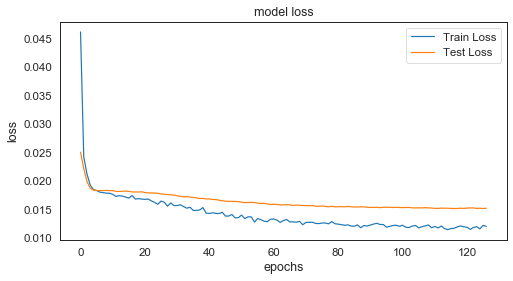

In [329]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

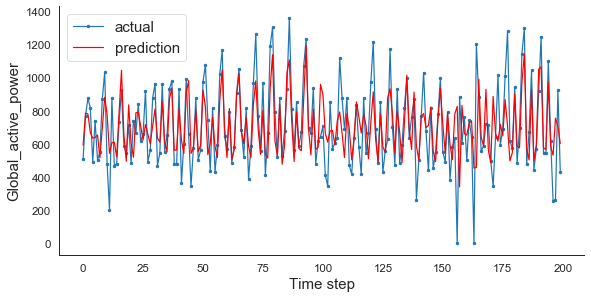

In [323]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### lookback 7 + day features + oil feature

In [338]:
df_temp_2 = df_temp.drop(['date', 'Day'],axis =1)
df_temp_2

,onpromotion_cat,year,day_of_year,day_of_week,week_of_year,month,quarter,weekday,dcoilwtico,y
0,0,2014,2,3,1,1,1,1,95.1400,966.1490
1,0,2014,3,4,1,1,1,1,93.6600,663.4050
2,0,2014,4,5,1,1,1,0,93.6600,1075.0000
3,0,2014,5,6,1,1,1,0,93.6600,892.6080
4,0,2014,6,0,2,1,1,1,93.1200,261.5540
...,...,...,...,...,...,...,...,...,...,...
1317,0,2017,223,4,32,8,3,1,48.8100,682.4450
1318,0,2017,224,5,32,8,3,0,48.8100,720.9130
1319,0,2017,225,6,32,8,3,0,48.8100,960.0430
1320,0,2017,226,0,33,8,3,1,47.5900,696.3690


In [405]:
df_temp_3 = df.drop(['date', 'Day','y'],axis =1)
dataset = df_temp_3.values
y = df['y'].values
y = np.reshape(y, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)
#y = scaler.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, y, test_size=0.3, random_state=1, shuffle = False)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Y_train_2 = []
for y in Y_train:
    Y_train_2.append(y[0])
Y_train = np.asarray(Y_train_2)

Y_test_2 = []
for y in Y_test:
    Y_test_2.append(y[0])
Y_test = np.asarray(Y_test_2)
print(X_train.shape,Y_train.shape)

(925, 1, 16) (925,)


In [406]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 925 samples, validate on 397 samples
Epoch 1/100
925/925 [==============================] - 2s 2ms/step - loss: 0.0936 - val_loss: 0.0434
Epoch 2/100
925/925 [==============================] - 0s 86us/step - loss: 0.0469 - val_loss: 0.0319
Epoch 3/100
925/925 [==============================] - 0s 83us/step - loss: 0.0401 - val_loss: 0.0255
Epoch 4/100
925/925 [==============================] - 0s 80us/step - loss: 0.0304 - val_loss: 0.0213
Epoch 5/100
925/925 [==============================] - 0s 79us/step - loss: 0.0242 - val_loss: 0.0186
Epoch 6/100
925/925 [==============================] - 0s 81us/step - loss: 0.0205 - val_loss: 0.0168
Epoch 7/100
925/925 [==============================] - 0s 80us/step - loss: 0.0185 - val_loss: 0.0158
Epoch 8/100
925/925 [==============================] - 0s 80us/step - loss: 0.0180 - val_loss: 0.0155
Epoch 9/100
925/925 [==============================] - 0s 85us/step - loss: 0.0173 - val_loss: 0.0152
Epoch 10/100
925/925 [===============

In [407]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 107.00159163338489
Train Root Mean Squared Error: 166.41488527708736
Test Mean Absolute Error: 132.63237276768143
Test Root Mean Squared Error: 183.77570786764116


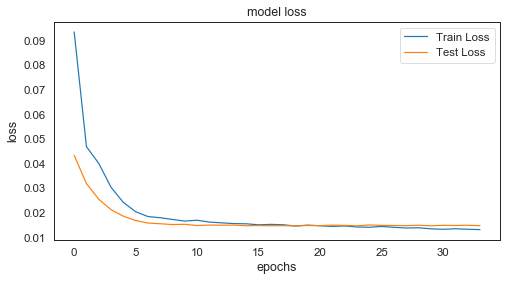

In [408]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

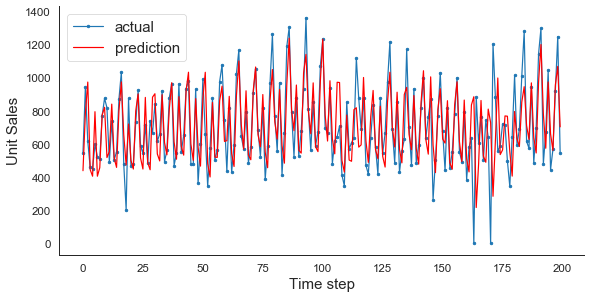

In [410]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Feedforward

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [184]:
#base NN

In [188]:
df_x = df.drop(['y'],axis = 1)
df_y = y
y = df_y.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(df_x.values, y, test_size=0.3, random_state=1, shuffle = False)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

AttributeError: 'list' object has no attribute 'values'

In [186]:
print(X_train.shape,X_test.shape)

(925, 15) (397, 15)


In [187]:
print(y_train.shape,y_test.shape)

(925,) (397,)


In [189]:
#build our model
def basic_model():
    model = Sequential()

    model.add(Dense(50, activation='relu',input_dim = 15))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(925,15)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
              
model_1 = basic_model()

In [200]:
model_1.fit(
    X_train,
    y_train,
    epochs=200,
    shuffle=False,
    verbose=2,
    batch_size =80
)

Epoch 1/200
 - 0s - loss: 11586.5211
Epoch 2/200
 - 0s - loss: 15939.0255
Epoch 3/200
 - 0s - loss: 19084.6358
Epoch 4/200
 - 0s - loss: 19102.7772
Epoch 5/200
 - 0s - loss: 14477.6934
Epoch 6/200
 - 0s - loss: 15172.8152
Epoch 7/200
 - 0s - loss: 13652.9354
Epoch 8/200
 - 0s - loss: 10523.4627
Epoch 9/200
 - 0s - loss: 11443.7912
Epoch 10/200
 - 0s - loss: 11940.4890
Epoch 11/200
 - 0s - loss: 9899.5070
Epoch 12/200
 - 0s - loss: 10363.7752
Epoch 13/200
 - 0s - loss: 9914.7609
Epoch 14/200
 - 0s - loss: 9317.0250
Epoch 15/200
 - 0s - loss: 9634.5555
Epoch 16/200
 - 0s - loss: 9562.7056
Epoch 17/200
 - 0s - loss: 9256.3626
Epoch 18/200
 - 0s - loss: 8994.1058
Epoch 19/200
 - 0s - loss: 9228.8254
Epoch 20/200
 - 0s - loss: 9185.6474
Epoch 21/200
 - 0s - loss: 9053.8977
Epoch 22/200
 - 0s - loss: 9023.2911
Epoch 23/200
 - 0s - loss: 9086.0836
Epoch 24/200
 - 0s - loss: 8829.4304
Epoch 25/200
 - 0s - loss: 8896.6567
Epoch 26/200
 - 0s - loss: 8789.9866
Epoch 27/200
 - 0s - loss: 8625.9374

In [201]:
prediction_train = model_1.predict(X_train)
prediction = model_1.predict(X_test)

In [238]:
print("RMSE:",math.sqrt(mean_squared_error(y_train,prediction_train)),"R2:",r2_score(prediction_train,y_train))

RMSE: 82.0364700603293 R2: 0.9595309748824855


In [240]:
print("RMSE:",math.sqrt(mean_squared_error(y_test,prediction)),"R2:",r2_score(prediction,y_test))

RMSE: 218.05888141995277 R2: 0.07888259520825391


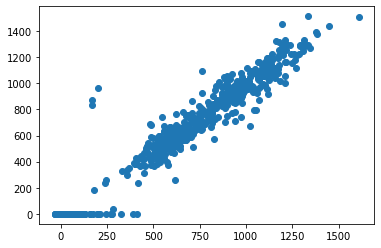

In [204]:
plt.scatter(prediction_train,y_train)


In [ ]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/